In [24]:
from pathlib import Path

import pandas as pd

DATA_DIR = Path("./pistachio_1_data")
df = pd.read_csv(DATA_DIR / "all_dyads.csv")

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_2808/730853519.py:6: DtypeWarning: Columns (36,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR / "all_dyads.csv")


In [ ]:
import xgboost as xgb

df["therapy_length_days"] = (
    pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])
).dt.days

df["day_of_week"] = pd.to_datetime(df["ActivityDateTime"]).dt.dayofweek
df["hour"] = pd.to_datetime(df["ActivityDateTime"]).dt.hour

# Select features
X = df.drop(
    [
        "tantrum_within_60m",
        "tantrum_within_15m",
        "tantrum_within_30m",
        "tantrum_within_45m",
        "DurationInSeconds",  # total active time
        "ActivityDateTime",
        "Arm",
        "Diagnosis",
        "CDI start date",
        "PDI start date",
        "PDI end date",
        "Type of medication",
        "Medication start date",
        "Week",
        "Therapy session",
        "Therapy Start",
        "Therapy End",
        "Education Status",
        "Parental Status",
        "Pre.ECBI",
        "Pre.ECBI.Prob",
        "Post.ECBI",
        "Post.ECBI.Prob",
        "dyad",
        "QuitStudy",
        "Employment Status",
        "ParticipatingParent.Sex",
        "Parent-PhoneType",
        # Data that is only available as "real time data" (more battery use?) in Companion SDK
        # NOTE: Removing these actually improves model accuracy?
        "DistanceInMeters",
        "ActiveKilocalories",
        "METmins",
        "METavg",
        "activity_seconds_sedentary",
        "activity_seconds_active",
        "activity_seconds_highly_active",
    ]
    # moving window stats
    + [
        "hr_moving_avg_15m",
        "hr_moving_std_15m",
        "hr_moving_min_15m",
        "hr_moving_max_15m",
        "hr_moving_avg_30m",
        "hr_moving_std_30m",
        "hr_moving_min_30m",
        "hr_moving_max_30m",
        "hr_moving_avg_45m",
        "hr_moving_std_45m",
        "hr_moving_min_45m",
        "hr_moving_max_45m",
    ],
    axis=1,
)
X = X.drop([col for col in X.columns if col.startswith("hr-prev")], axis=1)


def yn_to_bool(df):
    """
    Convert columns with 'Y'/'N' strings to boolean True/False.
    """
    for col in df.columns:
        if df[col].nunique() == 2 and set(df[col].dropna().unique()) == {"Y", "N"}:
            df[col] = df[col].map({"Y": True, "N": False})
    return df


X = yn_to_bool(X)

# Convert categorical columns to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Target variable
y30 = df["tantrum_within_30m"].astype(int)
y60 = df["tantrum_within_60m"].astype(int)

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_2808/91300247.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [ ]:
from numpy import mean, std
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
)


def evaluate_model(model, X, y, predict_every_nth: int = 1) -> None:
    # 1) Stratified K-folds maintains the distribution of positive and negative samples in each fold,
    # which is important for imbalanced datasets.
    # 2) Repeating lowers variance by repeating the cross-validation process multiple times.
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    f1_scores, precision_scores, recall_scores = [], [], []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)

        # Only predict on every nth row of the test set
        X_test_sub = X_test.iloc[::predict_every_nth].reset_index(drop=True)
        y_test_sub = y_test.iloc[::predict_every_nth].reset_index(drop=True)

        y_pred = model.predict(X_test_sub)

        f1_scores.append(f1_score(y_test_sub, y_pred))
        precision_scores.append(precision_score(y_test_sub, y_pred))
        recall_scores.append(recall_score(y_test_sub, y_pred))

    scores = {
        "test_f1": f1_scores,
        "test_precision": precision_scores,
        "test_recall": recall_scores,
    }

    # summarize performance
    print(f"Predict every {predict_every_nth} rows")
    print(f"F1: {mean(scores['test_f1']):.5f} +/- {std(scores['test_f1']):.5f}")
    print(
        f"Precision: {mean(scores['test_precision']):.5f} +/- {std(scores['test_precision']):.5f}"
    )
    print(
        f"Recall: {mean(scores['test_recall']):.5f} +/- {std(scores['test_recall']):.5f}"
    )
    print()

In [27]:
from sklearn.base import BaseEstimator


class SimpleModel(BaseEstimator):
    def __init__(self, threshold: int):
        self.threshold = threshold

    def fit(self, X, y):
        return self

    def predict(self, X):
        mean_hr = X["hr_moving_avg_60m"]
        return (mean_hr > 105) & (mean_hr < 129)

In [28]:
print("Simple HR threshold: predicting tantrums within 60m")
print()
y = y60
model = SimpleModel(threshold=100)
evaluate_model(model, X, y, predict_every_nth=1)
evaluate_model(model, X, y, predict_every_nth=2)
evaluate_model(model, X, y, predict_every_nth=4)

Simple HR threshold: predicting tantrums within 60m

Predict every 1 rows
F1: 0.01555 +/- 0.00017
Precision: 0.00795 +/- 0.00009
Recall: 0.36371 +/- 0.00382

Predict every 2 rows
F1: 0.01551 +/- 0.00020
Precision: 0.00793 +/- 0.00010
Recall: 0.36319 +/- 0.00617

Predict every 4 rows
F1: 0.01586 +/- 0.00062
Precision: 0.00811 +/- 0.00032
Recall: 0.36858 +/- 0.01355



In [29]:
print("Predicting tantrums within 60m")
print()
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

evaluate_model(model, X, y, predict_every_nth=1)
evaluate_model(model, X, y, predict_every_nth=2)
evaluate_model(model, X, y, predict_every_nth=4)

Predicting tantrums within 60m

Predict every 1 rows
F1: 0.20300 +/- 0.00426
Precision: 0.11733 +/- 0.00239
Recall: 0.75287 +/- 0.02561

Predict every 2 rows
F1: 0.20249 +/- 0.00459
Precision: 0.11698 +/- 0.00247
Recall: 0.75331 +/- 0.03097

Predict every 4 rows
F1: 0.20519 +/- 0.00413
Precision: 0.11881 +/- 0.00291
Recall: 0.75335 +/- 0.02344



In [30]:
print("Predicting tantrums within 30m")
print()

scale_pos_weight = y30.value_counts()[0] / y30.value_counts()[1]

model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

evaluate_model(model, X, y30, predict_every_nth=1)
evaluate_model(model, X, y30, predict_every_nth=2)
evaluate_model(model, X, y30, predict_every_nth=4)

Predicting tantrums within 30m

Predict every 1 rows
F1: 0.12113 +/- 0.00519
Precision: 0.06937 +/- 0.00323
Recall: 0.47842 +/- 0.02138

Predict every 2 rows
F1: 0.12193 +/- 0.00747
Precision: 0.06981 +/- 0.00429
Recall: 0.48200 +/- 0.03435

Predict every 4 rows
F1: 0.11508 +/- 0.01181
Precision: 0.06579 +/- 0.00667
Recall: 0.45945 +/- 0.05295



Baseline AUC-PR: 0.0050


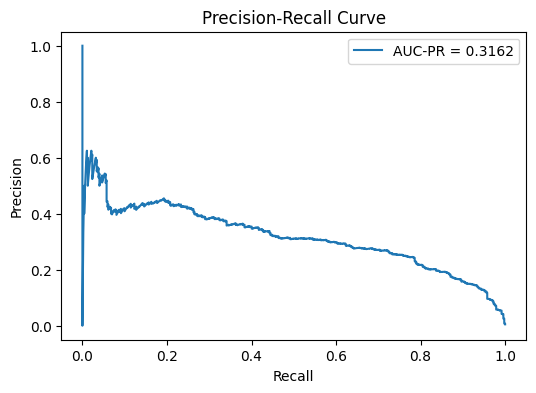

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Baseline AUC-PR: {1 / scale_pos_weight:.4f}")
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

conf_matrices = []
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

# Average confusion matrix over all folds
avg_conf_matrix = sum(conf_matrices) / len(conf_matrices)

plt.figure(figsize=(6, 4))
sns.heatmap(
    avg_conf_matrix,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"],
)
plt.title("Average Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

KeyboardInterrupt: 

In [ ]:
import shap

# https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
# Fit the model if not already fitted
model.fit(X, y)

# Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X)

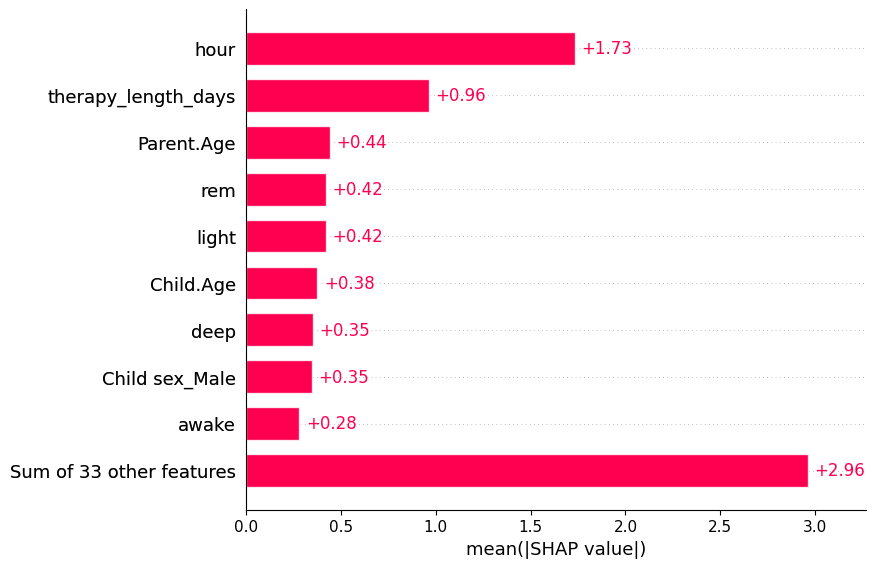

In [ ]:
# Mean shap values
shap.plots.bar(shap_values)

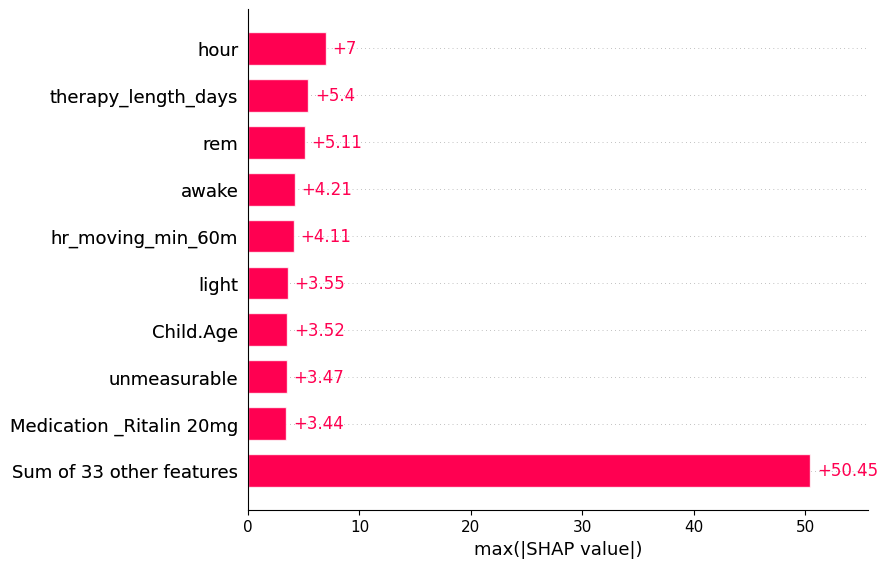

In [ ]:
# Absolute max value highlights features that have infrequent but strong impacts
shap.plots.bar(shap_values.abs.max(0))

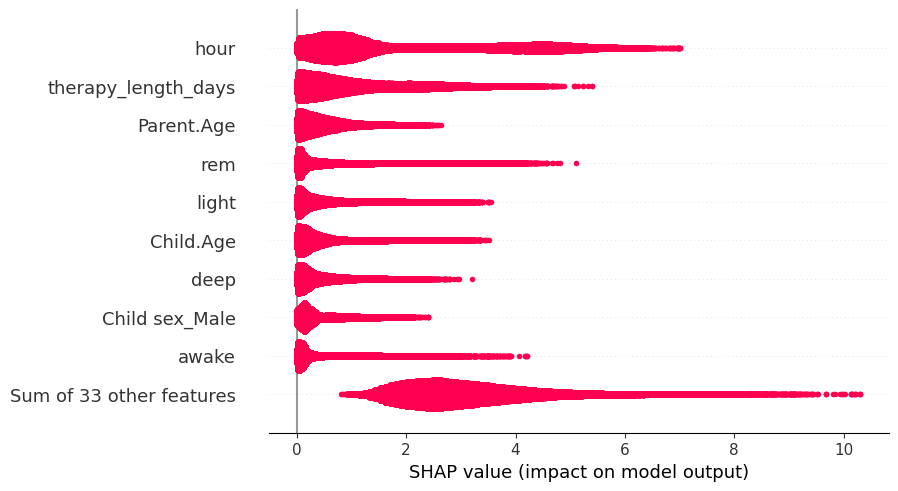

In [ ]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

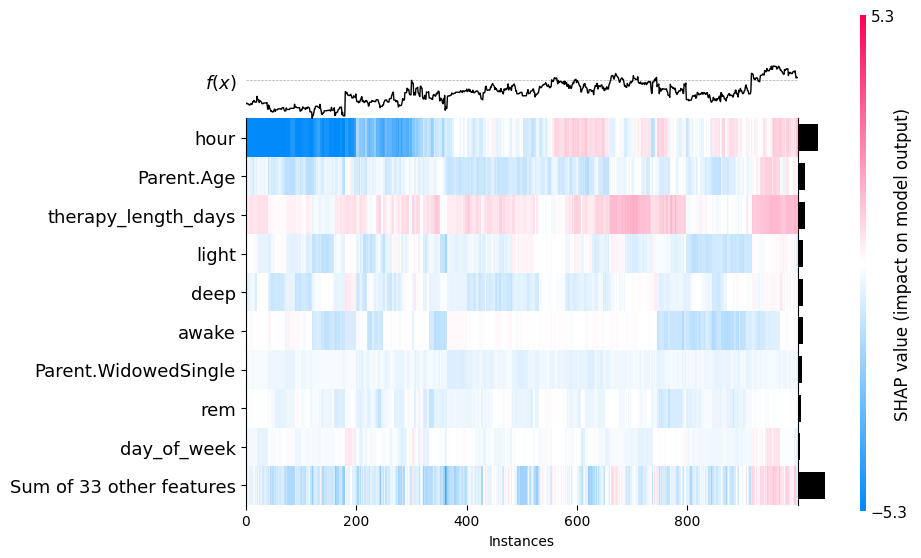

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(shap_values[:1000])

In [ ]:
y[y == 1]

785       1
786       1
787       1
788       1
803       1
         ..
468995    1
471005    1
471006    1
471007    1
471008    1
Name: tantrum_within_60m, Length: 2359, dtype: int64

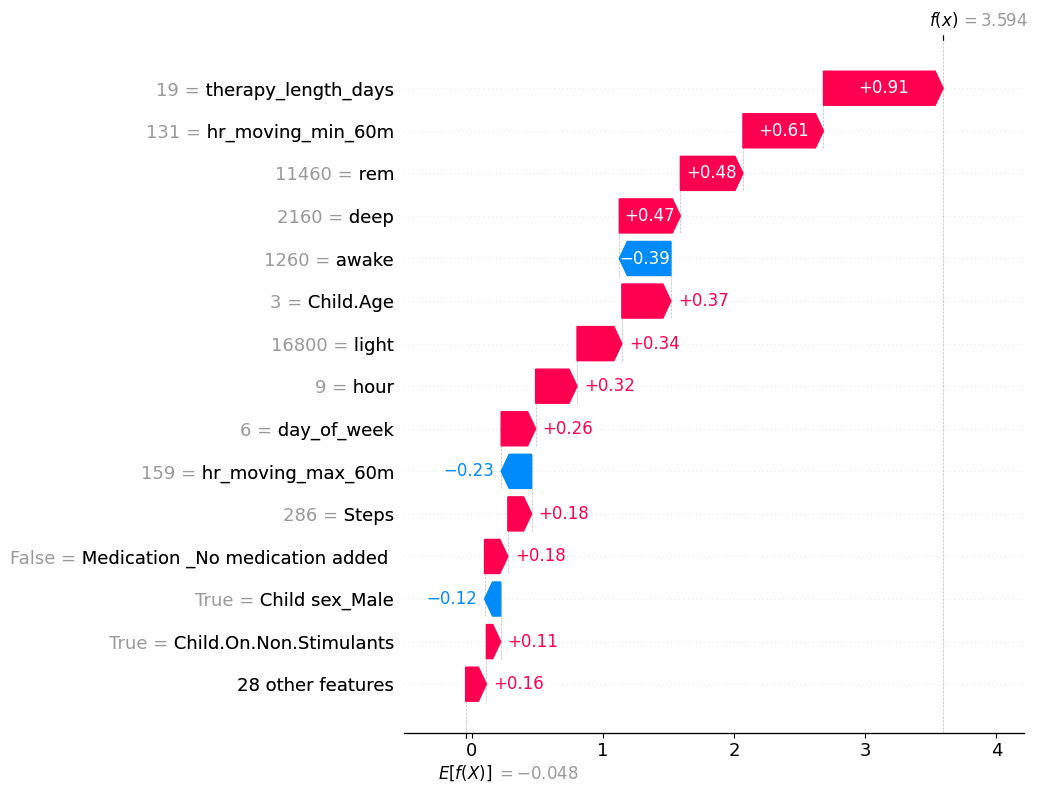

In [ ]:
shap.plots.waterfall(shap_values[466567], max_display=15)